### Estimators

Estimators 是 Tensorflow 的高级 API，封装了以下功能：
* training
* evaluation
* prediction
* export for serving

我们可以使用 pre-made Estimators 或者自己定制 Estimators，这两者都基于 tf.estimator.Estimater 类。

Estimators 的优势为：
* 可以在本地或分布式环境中运行 Estimator-based 的模型，而无需进行改动。此外，还可以跑在CPU、GPU 和 TPU 上。
* 提供了安全的分布式 training loop，控制如何及何时
  1. load data
  2. handle exceptions
  3. create checkpoint files and recover from failures
  4. save summaries for TensorBoard
  
 用 Estimators 时，将数据输入模块和模型分隔开。
 
 ### Pre-made Estimators
 
使用 Pre-made Estimators 比基础的 TensorFlow API 更概念化，无须担心创建计算图或 sessions。此外，pre-made Estimators 可以仅改动很少代码就可以实现不同的模型结构。比如，tf.estimators.DNNClassifier 是一个 pre-made Estimator，基于 dense, feed-forward 网络训练分类模型。

#### Stucture of a pre-made Estimators

设计基于 pre-made Estimator 的模型通常需要四步：
1. 一个或多个数据导入模块

比如，可能创建一个导入训练集的 function，和一个导入测试集的 function，每个数据导入功能必须返回两个对象：
* 一个 dictionary，key 为 feature name，value 为 Tensors（或 SparseTensors），包含对应的 feature data.
* Tensor，包含一个或多个标签

比如，下面的代码是 input function 的基本框架：

In [ ]:
def input_fn(dataset):
    ...  # manipulate dataset, extracting the feature dict and the label
    return feature_dict, lebel

2. 定义 feature columns

每个 tf.feature_column 指定 feature name，type, input pre-processing，下面的例子创建了三个 feature columns，前两个 feature columns 指定了 feature's name, type，第三个 feature column 还定义了 lambda 表示式：

In [ ]:
# Define three numeric feature columns.
population = tf.feature_column.numeric_column('population')
crime_rate = tf.feature_column.numeric_column('crime_rate')
median_education = tf.feature_column.numeric_column(
    'median_education',
    normalizer_fn=lambda x: x - global_education_mean)

3. 实例化相关的 pre-made Estimator

例子为名为 LinearClassifier 的 pre-made Estimator 的实例化：

In [ ]:
# Instantiate an estimator, passing the feature columns.
estimator = tf.estimator.LinearClassifier(
    feature_columns=[population, crime_rate, median_education])

4. 调用 training, evaluation, inference 方法

In [ ]:
# 'input_fn' is the function created in Step 1
estimator.train(input_fn=my_training_set, steps=2000)

如果不使用 pre-made Estimators，就必须自己实现 preceding features.

### Custom Estimators

Estimator 的核心是 model function，model function 是创建图来进行训练、评估、预测等的方法。当使用 pre-made Estimator 时，model function 是已经实现好的了，当使用定制 Estimator 时，需要自己实现 Estimator。

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

可以使用 tf.keras.estimator.model_to_estimator 将 Keras 模型转为 Estimator，这么做的好处是可以进行分布式训练。

In [3]:
keras_mobilenet_v2 = tf.keras.applications.MobileNetV2(input_shape=(160, 160, 3), include_top=False)
keras_mobilenet_v2.trainalbe = False

estimator_model = tf.keras.Sequential([
    keras_mobilenet_v2,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(1)
])

# Compile the model
estimator_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy'])

9412608/9406464 [==============================] - 2s 0us/step


In [5]:
est_mobilenet_v2 = tf.keras.estimator.model_to_estimator(keras_model=estimator_model)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using the Keras model provided.
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\kazh\\AppData\\Local\\Temp\\tmpdvlkif6b', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FF5DD88D30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0,

In [6]:
IMG_SIZE = 160  # All images will be resized to 160*160

def preprocess(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [7]:
def train_input_fn(batch_size):
    data = tfds.load('cats_vs_dogs', as_supervised=True)
    train_data = data['train']
    train_data = train_data.map(preprocess).shuffle(500).batch(batch_size)
    return train_data

调用 Estimator 的训练方法：

In [8]:
est_mobilenet_v2.train(input_fn=lambda: train_input_fn(32), steps=500)

Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


C:\Users\kazh\AppData\Roaming\Python\Python37\site-packages\urllib3\connectionpool.py:847: InsecureRequestWarning: Unverified HTTPS request is being made. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#ssl-warnings
  InsecureRequestWarning)


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Dataset cats_vs_dogs downloaded and prepared to C:\Users\kazh\tensorflow_datasets\cats_vs_dogs\2.0.1. Subsequent calls will reuse this data.
INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='C:\\Users\\kazh\\AppData\\Local\\Temp\\tmpdvlkif6b\\keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='C:\\Users\\kazh\\AppData\\Local\\Temp\\tmpdvlkif6b\\keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting from: C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\keras\keras_model.ckpt


INFO:tensorflow:Warm-starting from: C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\keras\keras_model.ckpt


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-started 158 variables.


INFO:tensorflow:Warm-started 158 variables.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt.


INFO:tensorflow:loss = 0.68413043, step = 0


INFO:tensorflow:loss = 0.68413043, step = 0


INFO:tensorflow:global_step/sec: 0.359472


INFO:tensorflow:global_step/sec: 0.359472


INFO:tensorflow:loss = 0.23285642, step = 100 (278.190 sec)


INFO:tensorflow:loss = 0.23285642, step = 100 (278.190 sec)


INFO:tensorflow:global_step/sec: 0.364304


INFO:tensorflow:global_step/sec: 0.364304


INFO:tensorflow:loss = 0.092917904, step = 200 (274.505 sec)


INFO:tensorflow:loss = 0.092917904, step = 200 (274.505 sec)


INFO:tensorflow:Saving checkpoints for 217 into C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt.


INFO:tensorflow:Saving checkpoints for 217 into C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt.


INFO:tensorflow:global_step/sec: 0.348542


INFO:tensorflow:global_step/sec: 0.348542


INFO:tensorflow:loss = 0.11653484, step = 300 (286.903 sec)


INFO:tensorflow:loss = 0.11653484, step = 300 (286.903 sec)


INFO:tensorflow:global_step/sec: 0.359595


INFO:tensorflow:global_step/sec: 0.359595


INFO:tensorflow:loss = 0.069667876, step = 400 (278.098 sec)


INFO:tensorflow:loss = 0.069667876, step = 400 (278.098 sec)


INFO:tensorflow:Saving checkpoints for 430 into C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt.


INFO:tensorflow:Saving checkpoints for 430 into C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt.


INFO:tensorflow:Loss for final step: 0.13700406.


INFO:tensorflow:Loss for final step: 0.13700406.


同样，调用 evaluate 方法：

In [9]:
est_mobilenet_v2.evaluate(input_fn=lambda: train_input_fn(32), steps=10)

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-23T14:38:52Z


INFO:tensorflow:Starting evaluation at 2020-04-23T14:38:52Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt-500


INFO:tensorflow:Restoring parameters from C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt-500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2020-04-23-14:38:58


INFO:tensorflow:Finished evaluation at 2020-04-23-14:38:58


INFO:tensorflow:Saving dict for global step 500: accuracy = 0.54375, global_step = 500, loss = 0.7890236


INFO:tensorflow:Saving dict for global step 500: accuracy = 0.54375, global_step = 500, loss = 0.7890236


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt-500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: C:\Users\kazh\AppData\Local\Temp\tmpdvlkif6b\model.ckpt-500


{'accuracy': 0.54375, 'loss': 0.7890236, 'global_step': 500}

### 再看两个例子：
1. Build a linear model with Estimators

In [12]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from six.moves import urllib
import tensorflow.compat.v2.feature_column as fc
import tensorflow as tf

In [13]:
# Load dataset.
dftrain = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/train.csv')
dfeval = pd.read_csv('https://storage.googleapis.com/tf-datasets/titanic/eval.csv')
y_train = dftrain.pop('survived')
y_eval = dfeval.pop('survived')
dftrain.head()

,sex,age,n_siblings_spouses,parch,fare,class,deck,embark_town,alone
0,male,22.0,1,0,7.2500,Third,unknown,Southampton,n
1,female,38.0,1,0,71.2833,First,C,Cherbourg,n
2,female,26.0,0,0,7.9250,Third,unknown,Southampton,y
3,female,35.0,1,0,53.1000,First,C,Southampton,n
4,male,28.0,0,0,8.4583,Third,unknown,Queenstown,y


In [14]:
dftrain.describe()

,age,n_siblings_spouses,parch,fare
count,627.000000,627.000000,627.000000,627.000000
mean,29.631308,0.545455,0.379585,34.385399
std,12.511818,1.151090,0.792999,54.597730
min,0.750000,0.000000,0.000000,0.000000
25%,23.000000,0.000000,0.000000,7.895800
50%,28.000000,0.000000,0.000000,15.045800
75%,35.000000,1.000000,0.000000,31.387500
max,80.000000,8.000000,5.000000,512.329200


In [15]:
dftrain.shape[0], dfeval.shape[0]

(627, 264)

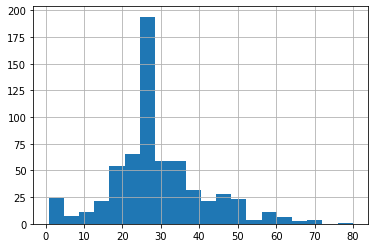

In [16]:
dftrain.age.hist(bins=20)

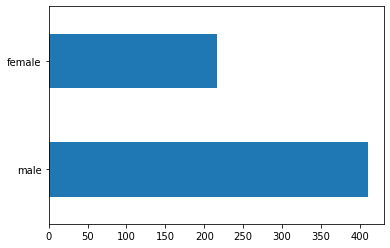

In [17]:
dftrain.sex.value_counts().plot(kind='barh')

Text(0.5, 0, '% survive')

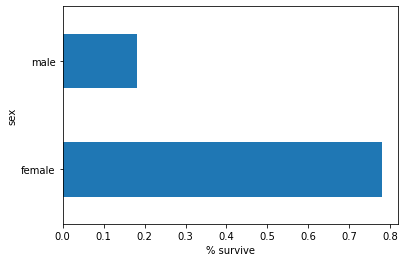

In [18]:
pd.concat([dftrain, y_train], axis=1).groupby('sex').survived.mean().plot(kind='barh').set_xlabel('% survive')

In [19]:
CATEGORICAL_COLUMNS = ['sex', 'n_siblings_spouses', 'parch', 'class', 'deck',
                       'embark_town', 'alone']
NUMERIC_COLUMNS = ['age', 'fare']
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = dftrain[feature_name].unique()
    feature_columns.append(tf.feature_column.categorical_column_with_vocabulary_list(feature_name, vocabulary))
for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(tf.feature_column.numeric_column(feature_name, dtype=tf.float32))

input_function 指明了数据是怎样转为 tf.data.Dataset 的，tf.data.Dataset 接收多种源，例如 dataframe, csv-formatted file 等。

In [20]:
def make_input_fn(data_df, label_df, num_epochs=10, shuffle=True, batch_size=32):
    def input_function():
        ds = tf.data.Dataset.from_tensor_slices((dict(data_df), label_df))
        if shuffle:
            ds = ds.shuffle(1000)
        ds = ds.batch(batch_size).repeat(num_epochs)
        return ds
    return input_function

train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, num_epochs=1, shuffle=False)

In [23]:
ds = make_input_fn(dftrain, y_train, batch_size=10)()
for feature_batch, label_batch in ds.take(1):
    print('Some feature keys:', list(feature_batch.keys()))
    print('A batch of class:', feature_batch['class'].numpy())
    print('A batch of Labels:', label_batch.numpy())

Some feature keys: ['sex', 'age', 'n_siblings_spouses', 'parch', 'fare', 'class', 'deck', 'embark_town', 'alone']
A batch of class: [b'Third' b'First' b'Third' b'Third' b'Third' b'Third' b'First' b'Third'
 b'Third' b'Third']
A batch of Labels: [1 1 0 0 1 0 1 0 0 0]


加入所有 base features 后，就可以训练模型了，直接调用 tf.estimator API:

In [26]:
linear_est = tf.estimator.LinearClassifier(feature_columns=feature_columns)
linear_est.train(train_input_fn)
result = linear_est.evaluate(eval_input_fn)

clear_output()
print(result)

{'accuracy': 0.77272725, 'accuracy_baseline': 0.625, 'auc': 0.8317417, 'auc_precision_recall': 0.7875298, 'average_loss': 0.4910239, 'label/mean': 0.375, 'loss': 0.4813112, 'precision': 0.7294118, 'prediction/mean': 0.322374, 'recall': 0.6262626, 'global_step': 200}


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.



If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\kazh\AppData\Local\Temp\tmplxkjccxh\model.ckpt-200


INFO:tensorflow:Restoring parameters from C:\Users\kazh\AppData\Local\Temp\tmplxkjccxh\model.ckpt-200


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


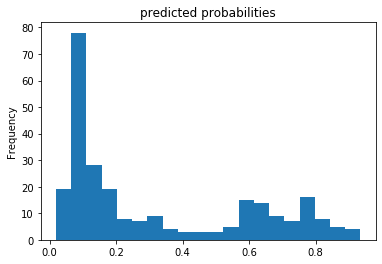

In [27]:
pred_dicts = list(linear_est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities')

(0, 1.05)

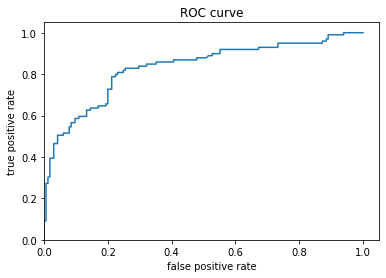

In [28]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,)

2. Create an Estimator from a Keras model

In [29]:
import tensorflow as tf

import numpy as np
import tensorflow_datasets as tfds

In [30]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(16, activation='relu', input_shape=(4,)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(3)
])

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                80        
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 51        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


**Create an input function**

Estimator 需要控制 input pipeline 合适及怎样被创建，这就需要实现 input_fn。Estimator 通过无参方式调用这个函数，input_fn 必须返回 tf.data.Dataset.

In [41]:
def input_fn():
    split = tfds.Split.TRAIN
    ds = tfds.load('iris', split=split, as_supervised=True)
    ds = ds.map(lambda features, labels: ({'dense_1_input': features}, labels))
    ds = ds.batch(32).repeat()
    return ds

In [39]:
for features_batch, labels_batch in input_fn().take(1):
    print(features_batch)
    print(labels_batch)

{'dense1_input': <tf.Tensor: id=44836, shape=(32, 4), dtype=float32, numpy=
array([[6.1, 2.8, 4.7, 1.2],
       [5.7, 3.8, 1.7, 0.3],
       [7.7, 2.6, 6.9, 2.3],
       [6. , 2.9, 4.5, 1.5],
       [6.8, 2.8, 4.8, 1.4],
       [5.4, 3.4, 1.5, 0.4],
       [5.6, 2.9, 3.6, 1.3],
       [6.9, 3.1, 5.1, 2.3],
       [6.2, 2.2, 4.5, 1.5],
       [5.8, 2.7, 3.9, 1.2],
       [6.5, 3.2, 5.1, 2. ],
       [4.8, 3. , 1.4, 0.1],
       [5.5, 3.5, 1.3, 0.2],
       [4.9, 3.1, 1.5, 0.1],
       [5.1, 3.8, 1.5, 0.3],
       [6.3, 3.3, 4.7, 1.6],
       [6.5, 3. , 5.8, 2.2],
       [5.6, 2.5, 3.9, 1.1],
       [5.7, 2.8, 4.5, 1.3],
       [6.4, 2.8, 5.6, 2.2],
       [4.7, 3.2, 1.6, 0.2],
       [6.1, 3. , 4.9, 1.8],
       [5. , 3.4, 1.6, 0.4],
       [6.4, 2.8, 5.6, 2.1],
       [7.9, 3.8, 6.4, 2. ],
       [6.7, 3. , 5.2, 2.3],
       [6.7, 2.5, 5.8, 1.8],
       [6.8, 3.2, 5.9, 2.3],
       [4.8, 3. , 1.4, 0.3],
       [4.8, 3.1, 1.6, 0.2],
       [4.6, 3.6, 1. , 0.2],
       [5.7, 4.4, 1.5, 0.

tf.keras.Model 可以使用 tf.estimator API 训练，方法是通过 tf.keras.estimator.model_to_estimator 将 tf.keras.Model 转为 tf.estimator.Estimator 对象。

In [35]:
import tempfile
model_dir = tempfile.mkdtemp()
keras_estimator = tf.keras.estimator.model_to_estimator(
    keras_model=model, model_dir=model_dir)

INFO:tensorflow:Using default config.


INFO:tensorflow:Using default config.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using the Keras model provided.


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\kazh\\AppData\\Local\\Temp\\tmp7hmmgdf7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FF01F06B38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\kazh\\AppData\\Local\\Temp\\tmp7hmmgdf7', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x000001FF01F06B38>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [42]:
keras_estimator.train(input_fn=input_fn, steps=500)
eval_result = keras_estimator.evaluate(input_fn=input_fn, steps=10)
print('Eval result: {}'.format(eval_result))

INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='C:\\Users\\kazh\\AppData\\Local\\Temp\\tmp7hmmgdf7\\keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting with WarmStartSettings: WarmStartSettings(ckpt_to_initialize_from='C:\\Users\\kazh\\AppData\\Local\\Temp\\tmp7hmmgdf7\\keras\\keras_model.ckpt', vars_to_warm_start='.*', var_name_to_vocab_info={}, var_name_to_prev_var_name={})


INFO:tensorflow:Warm-starting from: C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\keras\keras_model.ckpt


INFO:tensorflow:Warm-starting from: C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\keras\keras_model.ckpt


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-starting variables only in TRAINABLE_VARIABLES.


INFO:tensorflow:Warm-started 4 variables.


INFO:tensorflow:Warm-started 4 variables.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Create CheckpointSaverHook.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\model.ckpt.


INFO:tensorflow:Saving checkpoints for 0 into C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\model.ckpt.


INFO:tensorflow:loss = 3.0850353, step = 0


INFO:tensorflow:loss = 3.0850353, step = 0


INFO:tensorflow:global_step/sec: 164.474


INFO:tensorflow:global_step/sec: 164.474


INFO:tensorflow:loss = 1.3704013, step = 100 (0.611 sec)


INFO:tensorflow:loss = 1.3704013, step = 100 (0.611 sec)


INFO:tensorflow:global_step/sec: 174.825


INFO:tensorflow:global_step/sec: 174.825


INFO:tensorflow:loss = 0.8164963, step = 200 (0.571 sec)


INFO:tensorflow:loss = 0.8164963, step = 200 (0.571 sec)


INFO:tensorflow:global_step/sec: 175.438


INFO:tensorflow:global_step/sec: 175.438


INFO:tensorflow:loss = 0.56801164, step = 300 (0.570 sec)


INFO:tensorflow:loss = 0.56801164, step = 300 (0.570 sec)


INFO:tensorflow:global_step/sec: 176.367


INFO:tensorflow:global_step/sec: 176.367


INFO:tensorflow:loss = 0.57276267, step = 400 (0.567 sec)


INFO:tensorflow:loss = 0.57276267, step = 400 (0.567 sec)


INFO:tensorflow:Saving checkpoints for 500 into C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\model.ckpt.


INFO:tensorflow:Saving checkpoints for 500 into C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\model.ckpt.


INFO:tensorflow:Loss for final step: 0.512438.


INFO:tensorflow:Loss for final step: 0.512438.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Done calling model_fn.


INFO:tensorflow:Starting evaluation at 2020-04-23T16:08:23Z


INFO:tensorflow:Starting evaluation at 2020-04-23T16:08:23Z


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Graph was finalized.


INFO:tensorflow:Restoring parameters from C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\model.ckpt-500


INFO:tensorflow:Restoring parameters from C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\model.ckpt-500


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Done running local_init_op.


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [1/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [2/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [3/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [4/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [5/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [6/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [7/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [8/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [9/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Evaluation [10/10]


INFO:tensorflow:Finished evaluation at 2020-04-23-16:08:23


INFO:tensorflow:Finished evaluation at 2020-04-23-16:08:23


INFO:tensorflow:Saving dict for global step 500: global_step = 500, loss = 0.47769132


INFO:tensorflow:Saving dict for global step 500: global_step = 500, loss = 0.47769132


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\model.ckpt-500


INFO:tensorflow:Saving 'checkpoint_path' summary for global step 500: C:\Users\kazh\AppData\Local\Temp\tmp7hmmgdf7\model.ckpt-500


Eval result: {'loss': 0.47769132, 'global_step': 500}
